In [ ]:
# Links:
# https://www.askpython.com/python/examples/stock-price-prediction-python
# https://www.codespeedy.com/predicting-stock-price-using-lstm-python-ml/

In [1]:
%%capture
# %%capture: Show now output for this cell
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math

!pip install keras
!pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# https://pydata.github.io/pandas-datareader/
!pip install pandas-datareader
import pandas_datareader as pdr
# pickle
import pickle

# Data importing and visualization

In [2]:
def get_stock_data(ticker_symbols, start_date, end_date = datetime.today(), date_index = True, columns="all"):
    '''
    Returns stock data from yahoo for the specified ticker symbols, start and end dates.
    A dictionary is returned and the data for each stock can be accessed by data["ticker_symbol"]
    '''
    ticker_symbols = set(ticker_symbols)
    data = {}
    for ticker in ticker_symbols:
        df = pdr.data.DataReader(ticker, 'yahoo', start = start_date, end = end_date)
        if date_index:
            if "Date" in df.columns:
                df.set_index = df["Date"]
        else:
            df["Date"] = df.index
            df.index =  range(1, df.shape[0] + 1)
        if columns != "all":
            if len(columns) > 0:
                for column in df.columns:
                    if column not in columns:
                        df = df.drop([column], axis = 1)
        if df.isnull().sum().sum() != 0:
            print(f"WARN: {df.isnull().sum().sum() } data points are missing for ticker symbol {ticker}")
        data[ticker] = df
    return data

In [3]:
def plot_data(title, df):
    '''
    '''
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price in $")
    plt.show()

In [4]:
def tickers_as_columns(data_dict, column="Adj Close"):
    '''
    '''
    columns = []
    column_names = []
    for key in data_dict:
        column_names.append(key)
        columns.append(data_dict[key][column])
    df = pd.DataFrame(columns, index = column_names)
    return df.T

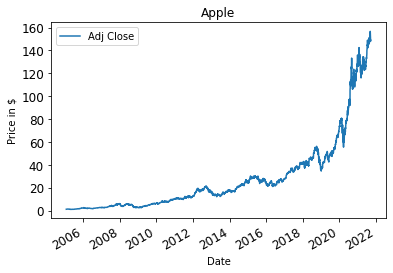

In [5]:
# Define a date range
start_date = datetime(2005, 1, 29)
end_date = datetime.today()

# Define ticker symbols
ticker_symbols = ['GOOG', "AAPL"]

# Create a dataframe with the apple stock price
apple_df = get_stock_data(ticker_symbols, start_date, end_date, columns=["Adj Close"])["AAPL"]

# Plot the data
plot_data(title="Apple" , df=apple_df)

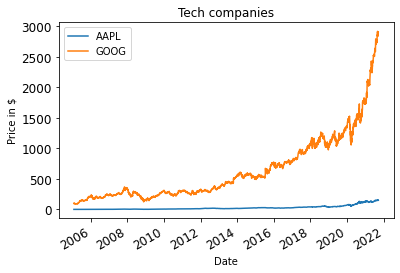

In [7]:
# Get data for multiple ticker symbols
data = get_stock_data(ticker_symbols, start_date)
formated_data = tickers_as_columns(data)

plot_data(title="Tech companies", df = formated_data)

## Functions for model training

In [8]:
def get_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(input_shape,1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [9]:
def train_test_split(dataset, days = 60):
    # Get the lenght of 70% of thedata
    training_data_len = math.ceil(len(dataset) *.7)
    # Get the training data
    train_data = dataset[0:training_data_len  , : ]

    # Separate the data into x and y data
    x_train = []
    y_train = []
    # Iterate from day 60 to the last day of the training data
    for i in range(days,len(train_data)):
        # I think these commands are useless
        # x_train=list(x_train)
        # y_train=list(y_train)
        x_train.append(train_data[i-days:i,0])
        y_train.append(train_data[i,0])

    # Converting the training x and y values to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshaping training s and y data to make the calculations easier
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
 
    # Creating a dataset for testing
    test_data = dataset[training_data_len - days: , : ]
    x_test = []
    y_test =  dataset[training_data_len : , : ]
    for i in range(days,len(test_data)):
        x_test.append(test_data[i-days:i,0])

    # 2.  Convert the values into arrays for easier computation
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    return x_train, y_train, x_test, y_test, training_data_len

In [10]:
def print_rmse(predictions, y_test): 
    rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
    print(rmse)
    return rmse

In [11]:
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale/Normalize the data to make all values between 0 and 1
    dataset = scaler.fit_transform(data)
    return scaler, dataset

In [12]:
def rescale_data(data, scaler):
    return scaler.inverse_transform(data)

In [13]:
def make_predictions(model, data):
    predictions =  model.predict(data).reshape(-1, 1)
    return predictions

In [14]:
def plot_approximation(filtered_data, training_data_len, predictions):
    train = filtered_data[:training_data_len]
    valid = filtered_data[training_data_len:].copy()
    valid.loc[:,'Predictions'] = predictions

    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close')

    plt.plot(train['GOOG'])
    plt.plot(valid[['GOOG', 'Predictions']])

    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

    plt.show()

In [15]:
def store_model_pickle(name, model):
    try:
        model_params = model.get_params()
        fileObj = open(f'./models/{name}_params.obj', 'wb')
        pickle.dump(model_params,fileObj)
        fileObj.close()
    except:
        pass
    fileObj = open(f'{name}.obj', 'wb')
    pickle.dump(model,fileObj)
    fileObj.close()
    
def store_model_keras(name, model):
    model.save(f'./models/{name}', save_format="h5" )  # creates a HDF5 file 'my_model.h5'

In [16]:
def load_model(model_name):
    model = tf.keras.models.load_model(f"./models/{model_name}")
    return model

In [17]:
# date range

## Preprocess the data and divide it into train and test set

In [18]:
# This takes a subset of the dataframe which is still a dataframe with 2D (len,1)
filtered_data = formated_data.filter(['GOOG'])
# I assume this creates a Pandas Series object which is just 1D
# close_data = formated_data['GOOG']
# 2. Convert the data into array for easy evaluation
dataset = filtered_data.values

pred_base_range = 60

scaler, dataset = scale_data(dataset)
x_train, y_train, x_test, y_test, training_data_len = train_test_split(dataset, days = pred_base_range)

### Create model

In [19]:
# first_lstm = get_model(input_shape = x_train.shape[1])
# first_lstm.fit(x_train, y_train, batch_size=1, epochs=1)
# store_model_keras("first_lstm", first_lstm)

### Load model from disk

In [20]:
first_lstm = load_model("first_lstm")

2021-09-15 22:20:16.020348: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 22:20:16.020721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-15 22:20:16.022060: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model_dict = {}
model_dict["name"] = "first_lstm"
model_dict["model"] = first_lstm
model_dict["start_date"] = start_date
model_dict["end_date"] = end_date
model_dict["ticker_symbols"] = ["GOOG"]
model_dict["pred_base_range"] =  pred_base_range

In [49]:
def make_prediction(model_dict, dates, ticker_symbols):
    '''
    
    '''
    pred_base_range = model_dict["pred_base_range"]
    
    # Check if the model was trained for all the provided ticker symbols:
    ticker_symbols = set(ticker_symbols)
    tickers_to_remove = []
    for ticker in ticker_symbols:
        if ticker not in model_dict["ticker_symbols"]:
            print(f"WARN: model {model_dict['name']} was not trained to predict prices for {ticker}!")
            tickers_to_remove.append(ticker)
    
    for ticker in tickers_to_remove:
            ticker_symbols.remove(ticker)
            
    # Check if the date ranges are outside the range which were used for training:
    dates = set(dates)
    dates_to_remove = []
    for date in dates:
        if (date > model_dict["start_date"]) and (date < model_dict["end_date"]):
            print(f"WARN: model {model_dict['name']}  was trained with the date {date} and therefore no predictions for that date can be made!")
            dates_to_remove.append(date)
    for date in dates_to_remove:
        dates.remove(date)
            
    # Initialize a result dictionary
    result = {}
    for ticker in ticker_symbols:
        result[ticker] = {}
        # sort dates so there is no need to predict a day twice
        for target_date in dates:
            print(f"Predicting {ticker} price for {target_date}") 
            start_date = datetime.today() - timedelta(days=pred_base_range)
            # if the date is to far in the future, multiple iterations are necessary
            
            delta = target_date - datetime.today() # as timedelta to predict

            # If no Adj close is available for today, today also needs to be predicted
            for i in range(1, delta.days + 2):
                day = datetime.today() + timedelta(days=i)
                print(day)
            
            
            available_data = get_stock_data(ticker_symbols = [ticker], start_date =  start_date, end_date = datetime.today(), date_index = True, columns="all")
            formated_data = tickers_as_columns(available_data)
            filtered_data = formated_data.filter([ticker])
            dataset = filtered_data.values
            scaler, y_test = scale_data(dataset)
            print(y_test.shape)
            
            prediction = 0
            result[ticker][target_date] = prediction
        
    return result

In [50]:
test_dates = []
test_dates.append(datetime(year = 2021, month = 9, day = 15))
test_dates.append(datetime(year = 2021, month = 9, day = 17))
test_dates.append(datetime(year = 2020, month = 9, day = 17))
test_dates.append(datetime(year = 2021, month = 10, day = 17))

In [51]:
make_prediction(model_dict, dates=test_dates, ticker_symbols=["GOOG"])

WARN: model first_lstm  was trained with the date 2021-09-15 00:00:00 and therefore no predictions for that date can be made!
WARN: model first_lstm  was trained with the date 2020-09-17 00:00:00 and therefore no predictions for that date can be made!
Predicting GOOG price for 2021-09-17 00:00:00
2021-09-16 22:28:08.411923
2021-09-17 22:28:08.412006
(42, 1)
Predicting GOOG price for 2021-10-17 00:00:00
2021-09-16 22:28:09.165973
2021-09-17 22:28:09.165991
2021-09-18 22:28:09.166006
2021-09-19 22:28:09.166021
2021-09-20 22:28:09.166035
2021-09-21 22:28:09.166049
2021-09-22 22:28:09.166064
2021-09-23 22:28:09.166079
2021-09-24 22:28:09.166093
2021-09-25 22:28:09.166108
2021-09-26 22:28:09.166122
2021-09-27 22:28:09.166136
2021-09-28 22:28:09.166151
2021-09-29 22:28:09.166165
2021-09-30 22:28:09.166180
2021-10-01 22:28:09.166194
2021-10-02 22:28:09.166209
2021-10-03 22:28:09.166224
2021-10-04 22:28:09.166239
2021-10-05 22:28:09.166253
2021-10-06 22:28:09.166268
2021-10-07 22:28:09.166283


{'GOOG': {datetime.datetime(2021, 9, 17, 0, 0): 0,
  datetime.datetime(2021, 10, 17, 0, 0): 0}}

In [52]:
x_test

array([[[0.20535658],
        [0.2095196 ],
        [0.21095793],
        ...,
        [0.24091548],
        [0.23979167],
        [0.24180956]],

       [[0.2095196 ],
        [0.21095793],
        [0.21378158],
        ...,
        [0.23979167],
        [0.24180956],
        [0.2435094 ]],

       [[0.21095793],
        [0.21378158],
        [0.21629425],
        ...,
        [0.24180956],
        [0.2435094 ],
        [0.24739326]],

       ...,

       [[0.86237974],
        [0.8567007 ],
        [0.86297351],
        ...,
        [0.9932253 ],
        [0.99343738],
        [0.97228648]],

       [[0.8567007 ],
        [0.86297351],
        [0.86682198],
        ...,
        [0.99343738],
        [0.97228648],
        [0.98319945]],

       [[0.86297351],
        [0.86682198],
        [0.86301941],
        ...,
        [0.97228648],
        [0.98319945],
        [0.98278247]]])

In [26]:
# Making predictions on the testing data
rescaled_predictions = make_predictions(first_lstm, x_test)
predictions = rescale_data(rescaled_predictions, scaler)

2021-09-15 22:20:20.735930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-15 22:20:20.757976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


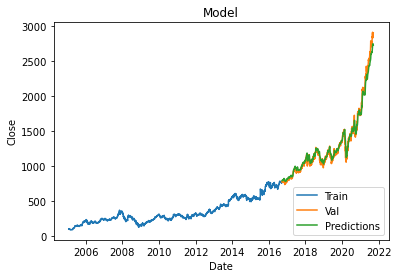

In [27]:
plot_approximation(filtered_data=filtered_data, training_data_len= training_data_len, predictions=predictions)